
--- 1. Memuat Dataset Gabungan ---
✅ DataBerita.csv dimuat (614 data)
✅ turnbackhoax.csv dimuat (3071 data)
✅ berita.csv dimuat (541 data)
✅ DataDetik.csv dimuat (4945 data)
✅ Total data setelah pembersihan: 7205

--- 2. Pra-pemrosesan ---
✅ Contoh teks bersih:
 jember kompas com dinas kesehatan dinkes kabupaten jember jawa timur mengungkap hasil uji laboratori ...
⚙️  Menambahkan noise label sebanyak 360 data (≈5%)

--- 4. Eksperimen Model ---

🧠 Kernel: linear | Fitur: 2000
Akurasi   : 88.95%
Presisi   : 89.08%
Recall    : 99.74%
F1-Score  : 94.11%
Confusion Matrix:
 [[  14  234]
 [   5 1909]]


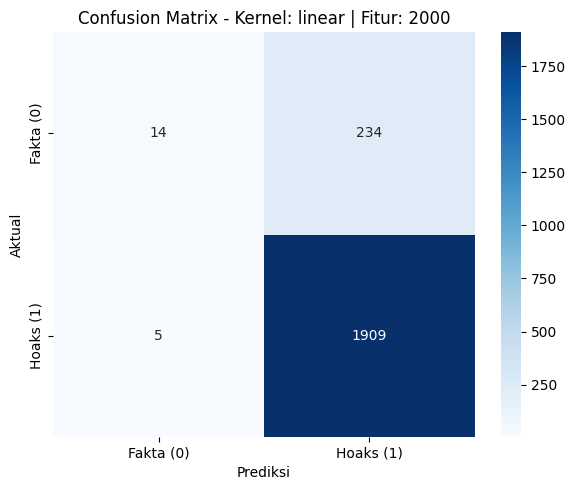


🧠 Kernel: linear | Fitur: 500
Akurasi   : 89.08%
Presisi   : 89.06%
Recall    : 99.95%
F1-Score  : 94.19%
Confusion Matrix:
 [[  13  235]
 [   1 1913]]


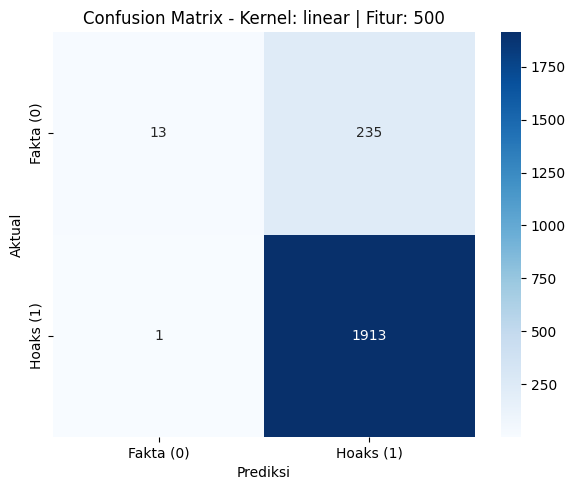


🧠 Kernel: rbf | Fitur: 2000
Akurasi   : 88.02%
Presisi   : 88.80%
Recall    : 98.96%
F1-Score  : 93.60%
Confusion Matrix:
 [[   9  239]
 [  20 1894]]


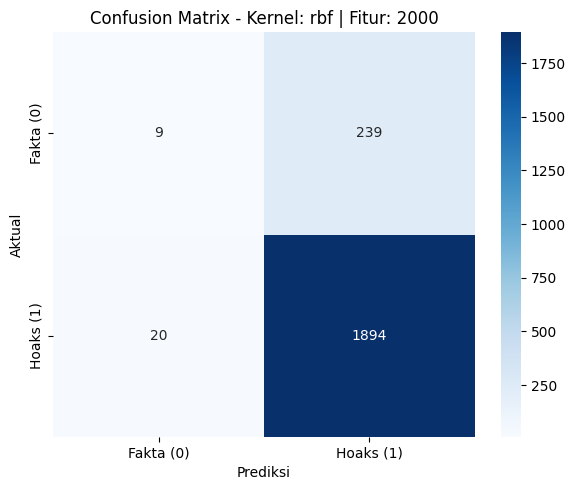


🧠 Kernel: rbf | Fitur: 500
Akurasi   : 88.90%
Presisi   : 89.30%
Recall    : 99.37%
F1-Score  : 94.07%
Confusion Matrix:
 [[  20  228]
 [  12 1902]]


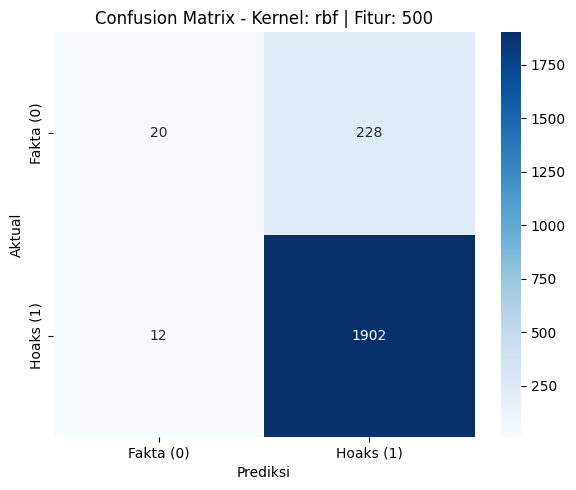


--- 5. Hasil Evaluasi ---
   Kernel  Fitur  Akurasi  Presisi  Recall  F1-Score
0  linear   2000    88.95    89.08   99.74     94.11
1  linear    500    89.08    89.06   99.95     94.19
2     rbf   2000    88.02    88.80   98.96     93.60
3     rbf    500    88.90    89.30   99.37     94.07

📁 Hasil disimpan di: Hasil_Eksperimen_SVM.csv


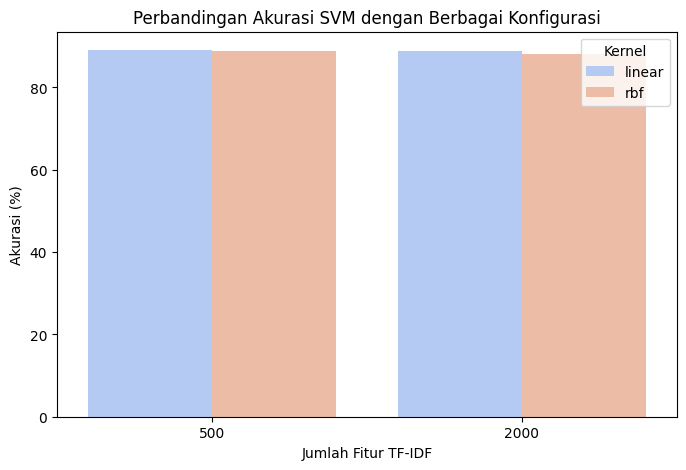

In [1]:
# ===============================================================
# EKSPERIMEN PERBANDINGAN MODEL SVM UNTUK DETEKSI HOAKS
# ===============================================================
import pandas as pd
import numpy as np
import re, random
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)

# ===============================================================
# 1. MEMUAT DAN MENYIAPKAN DATASET
# ===============================================================
print("\n--- 1. Memuat Dataset Gabungan ---")

files = ['DataBerita.csv', 'turnbackhoax.csv', 'berita.csv', 'DataDetik.csv']
dataframes = []

for file in files:
    try:
        df_temp = pd.read_csv(file)

        # Normalisasi kolom
        if 'Content' in df_temp.columns:
            df_temp.rename(columns={'Content': 'teks_berita'}, inplace=True)
            if 'label' not in df_temp.columns:
                df_temp['label'] = 'hoaks'
        elif 'Title' in df_temp.columns and 'teks_berita' not in df_temp.columns:
            df_temp.rename(columns={'Title': 'teks_berita'}, inplace=True)
            df_temp['label'] = 'hoaks'

        dataframes.append(df_temp)
        print(f"✅ {file} dimuat ({len(df_temp)} data)")
    except FileNotFoundError:
        print(f"⚠️  {file} tidak ditemukan.")

if not dataframes:
    raise FileNotFoundError("Tidak ada file CSV ditemukan!")

df = pd.concat(dataframes, ignore_index=True)
df = df.dropna(subset=['label', 'teks_berita']).drop_duplicates(subset='teks_berita')
df = df.reset_index(drop=True)
print(f"✅ Total data setelah pembersihan: {len(df)}")

# ===============================================================
# 2. PRA-PROSES TEKS
# ===============================================================
print("\n--- 2. Pra-pemrosesan ---")
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)  # ✅ Tambahkan ini untuk memperbaiki LookupError
stop_words = set(stopwords.words('indonesian'))

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
    return ' '.join(tokens)

df['text_cleaned'] = df['teks_berita'].apply(preprocess_text)
print("✅ Contoh teks bersih:\n", df['text_cleaned'].iloc[0][:100], "...")

# ===============================================================
# 3. OPSIONAL: TAMBAH NOISE PADA LABEL
# ===============================================================
RUN_LABEL_FLIP = True
LABEL_FLIP_PCT = 0.05  # 5% label akan diacak

if RUN_LABEL_FLIP:
    n_flip = int(len(df) * LABEL_FLIP_PCT)
    flip_idx = np.random.choice(df.index, size=n_flip, replace=False)
    df.loc[flip_idx, 'label'] = df.loc[flip_idx, 'label'].apply(lambda x: 'fakta' if x == 'hoaks' else 'hoaks')
    print(f"⚙️  Menambahkan noise label sebanyak {n_flip} data (≈{LABEL_FLIP_PCT*100:.0f}%)")

# ===============================================================
# 4. EKSPERIMEN DENGAN BEBERAPA KONFIGURASI MODEL
# ===============================================================
print("\n--- 4. Eksperimen Model ---")
configs = [
    {'kernel': 'linear', 'features': 2000},
    {'kernel': 'linear', 'features': 500},
    {'kernel': 'rbf', 'features': 2000},
    {'kernel': 'rbf', 'features': 500},
]

results = []

for cfg in configs:
    print(f"\n🧠 Kernel: {cfg['kernel']} | Fitur: {cfg['features']}")
    vectorizer = TfidfVectorizer(max_features=cfg['features'])
    X = vectorizer.fit_transform(df['text_cleaned']).toarray()
    y = df['label'].apply(lambda x: 1 if x.lower() == 'hoaks' else 0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    model = SVC(kernel=cfg['kernel'], random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    # --- Cetak hasil evaluasi ---
    print(f"Akurasi   : {acc*100:.2f}%")
    print(f"Presisi   : {prec*100:.2f}%")
    print(f"Recall    : {rec*100:.2f}%")
    print(f"F1-Score  : {f1*100:.2f}%")
    print("Confusion Matrix:\n", cm)

    # --- Visualisasi Confusion Matrix ---
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Fakta (0)', 'Hoaks (1)'],
        yticklabels=['Fakta (0)', 'Hoaks (1)']
    )
    plt.title(f"Confusion Matrix - Kernel: {cfg['kernel']} | Fitur: {cfg['features']}")
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.tight_layout()
    plt.show()

    results.append({
        'Kernel': cfg['kernel'],
        'Fitur': cfg['features'],
        'Akurasi': round(acc*100, 2),
        'Presisi': round(prec*100, 2),
        'Recall': round(rec*100, 2),
        'F1-Score': round(f1*100, 2)
    })

# ===============================================================
# 5. HASIL EVALUASI DALAM TABEL
# ===============================================================
print("\n--- 5. Hasil Evaluasi ---")
results_df = pd.DataFrame(results)
print(results_df)

# Simpan hasil ke file CSV
results_df.to_csv("Hasil_Eksperimen_SVM.csv", index=False)
print("\n📁 Hasil disimpan di: Hasil_Eksperimen_SVM.csv")

# ===============================================================
# 6. VISUALISASI PERBANDINGAN AKURASI
# ===============================================================
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='Fitur', y='Akurasi', hue='Kernel', palette='coolwarm')
plt.title('Perbandingan Akurasi SVM dengan Berbagai Konfigurasi')
plt.xlabel('Jumlah Fitur TF-IDF')
plt.ylabel('Akurasi (%)')
plt.legend(title='Kernel')
plt.show()



--- 1. Memuat Dataset ---
✅ DataBerita.csv dimuat (614 data)
✅ turnbackhoax.csv dimuat (3071 data)
✅ berita.csv dimuat (541 data)
✅ DataDetik.csv dimuat (4945 data)
✅ Total data setelah pembersihan: 7205

--- 2. Pra-pemrosesan ---


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



--- 3. Menyeimbangkan data dan menambah sedikit noise label ---
📊 Sebaran awal label:
label
hoaks    6692
fakta     513
Name: count, dtype: int64

⚙️ Menyeimbangkan data berdasarkan jumlah minimum: 513 per kelas
✅ Data setelah balancing: 1026 baris
label
fakta    513
hoaks    513
Name: count, dtype: int64
⚙️ Menambahkan noise label sebanyak 51 data (~5%)
📊 Distribusi label akhir setelah noise:
label
hoaks    514
fakta    512
Name: count, dtype: int64


--- 4. Eksperimen Model SVM ---

🧠 Kernel: linear | Fitur: 1000 | C=1.0
 Akurasi  : 79.38%
 Presisi  : 77.94%
 Recall   : 82.17%
 F1-Score : 80.00%
🖼️ Confusion Matrix disimpan sebagai: Confusion_Matrix_linear_1000.png

🧠 Kernel: rbf | Fitur: 1000 | C=1.0
 Akurasi  : 78.99%
 Presisi  : 77.37%
 Recall   : 82.17%
 F1-Score : 79.70%
🖼️ Confusion Matrix disimpan sebagai: Confusion_Matrix_rbf_1000.png

--- 5. Hasil Evaluasi ---
   Kernel  Fitur  Akurasi  Presisi  Recall  F1-Score
0  linear   1000    79.38    77.94   82.17      80.0
1     rbf

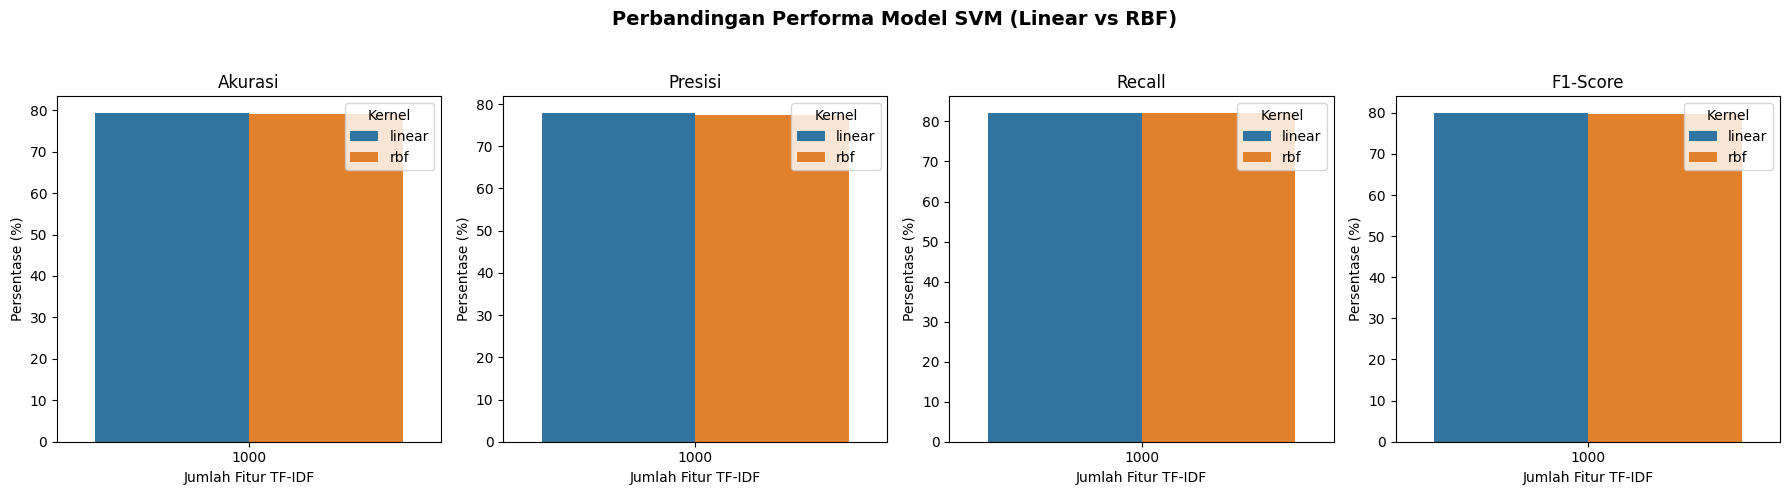


--- 6. Pelatihan Ulang Model Terbaik ---
🔥 Model terbaik: Kernel=linear, Fitur=1000

--- 7. Prediksi Berita dari Link ---

🔗 Menganalisis link: https://www.detik.com/jabar/berita/d-8124684/belasan-siswa-smk-di-bandung-barat-diduga-keracunan-usai-santap-mbg

🔎 Hasil Deteksi: FAKTA ✅
📈 Tingkat Keyakinan: 73.26%

📰 Cuplikan teks berita:
Program Makan Bergizi Gratis (MBG) kembali memicu keracunan massal. Kali ini belasan siswa SMK di Desa Sirnagalih, Kecamatan Cipongkor, Kabupaten Bandung Barat yang jadi korban. Para siswa SMK yang diduga keracunan itu mengeluhkan gejala khas keracunan setelah menyantap menu MBG yang dibagikan pada Senin siang. Gejala dirasakan beberapa jam berselang setelah menu dikonsumsi. SCROLL TO CONTINUE WIT ...



In [2]:
# ===============================================================
# DETEKSI HOAKS MENGGUNAKAN SUPPORT VECTOR MACHINE (SVM)
# ===============================================================
# Dilengkapi: Akurasi, Presisi, Recall, F1, Confusion Matrix, dan Visualisasi Hasil
# ===============================================================

import pandas as pd
import numpy as np
import re, random, requests
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)

# ===============================================================
# 1. MEMUAT DATASET
# ===============================================================
print("\n--- 1. Memuat Dataset ---")

files = ['DataBerita.csv', 'turnbackhoax.csv', 'berita.csv', 'DataDetik.csv']
dataframes = []

for file in files:
    try:
        df_temp = pd.read_csv(file)
        if 'Content' in df_temp.columns:
            df_temp.rename(columns={'Content': 'teks_berita'}, inplace=True)
        elif 'Title' in df_temp.columns:
            df_temp.rename(columns={'Title': 'teks_berita'}, inplace=True)
        if 'label' not in df_temp.columns:
            df_temp['label'] = 'hoaks'
        dataframes.append(df_temp)
        print(f"✅ {file} dimuat ({len(df_temp)} data)")
    except FileNotFoundError:
        print(f"⚠️ {file} tidak ditemukan.")

if not dataframes:
    raise FileNotFoundError("Tidak ada file CSV ditemukan!")

df = pd.concat(dataframes, ignore_index=True)
df = df.dropna(subset=['label', 'teks_berita']).drop_duplicates(subset='teks_berita')
df = df.reset_index(drop=True)
print(f"✅ Total data setelah pembersihan: {len(df)}")

# ===============================================================
# 2. PRA-PROSES TEKS
# ===============================================================
print("\n--- 2. Pra-pemrosesan ---")

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('indonesian'))

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
    return ' '.join(tokens)

df['text_cleaned'] = df['teks_berita'].apply(preprocess_text)

# ===============================================================
# 3. PENYEIMBANGAN DATA & LABEL NOISE TERKONTROL (Versi Aman)
# ===============================================================
print("\n--- 3. Menyeimbangkan data dan menambah sedikit noise label ---")

# Pastikan kolom label ada
if 'label' not in df.columns:
    raise ValueError("Kolom 'label' tidak ditemukan di DataFrame!")

# Menyamakan jumlah kelas agar seimbang
label_counts = df['label'].value_counts()
min_count = label_counts.min()

print(f"📊 Sebaran awal label:\n{label_counts}\n")
print(f"⚙️ Menyeimbangkan data berdasarkan jumlah minimum: {min_count} per kelas")

# Sampling data agar seimbang antar kelas
balanced_frames = []
for lbl in df['label'].unique():
    subset = df[df['label'] == lbl]
    balanced_frames.append(subset.sample(min_count, random_state=42))

df_balanced = pd.concat(balanced_frames, ignore_index=True)
print(f"✅ Data setelah balancing: {len(df_balanced)} baris")
print(df_balanced['label'].value_counts())

# Tambahkan noise label kecil (5%)
LABEL_FLIP_PCT = 0.05
n_flip = int(len(df_balanced) * LABEL_FLIP_PCT)
flip_idx = np.random.choice(df_balanced.index, size=n_flip, replace=False)

df_balanced.loc[flip_idx, 'label'] = df_balanced.loc[flip_idx, 'label'].apply(
    lambda x: 'fakta' if x == 'hoaks' else 'hoaks'
)

print(f"⚙️ Menambahkan noise label sebanyak {n_flip} data (~{LABEL_FLIP_PCT*100:.0f}%)")
print(f"📊 Distribusi label akhir setelah noise:\n{df_balanced['label'].value_counts()}\n")

# ===============================================================
# 4. EKSPERIMEN MODEL SVM
# ===============================================================
print("\n--- 4. Eksperimen Model SVM ---")

configs = [
    {'kernel': 'linear', 'features': 1000, 'C': 1.0},
    {'kernel': 'rbf', 'features': 1000, 'C': 1.0},
]

results = []

for cfg in configs:
    print(f"\n🧠 Kernel: {cfg['kernel']} | Fitur: {cfg['features']} | C={cfg['C']}")
    vectorizer = TfidfVectorizer(max_features=cfg['features'])
    X = vectorizer.fit_transform(df_balanced['text_cleaned']).toarray()
    y = df_balanced['label'].apply(lambda x: 1 if x.lower() == 'hoaks' else 0)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    model = SVC(kernel=cfg['kernel'], C=cfg['C'], random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f" Akurasi  : {acc*100:.2f}%")
    print(f" Presisi  : {pre*100:.2f}%")
    print(f" Recall   : {rec*100:.2f}%")
    print(f" F1-Score : {f1*100:.2f}%")

    # === Confusion Matrix ===
    cm = confusion_matrix(y_test, y_pred)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5, 4))
    sns.heatmap(cmn, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=['Fakta (0)', 'Hoaks (1)'],
                yticklabels=['Fakta (0)', 'Hoaks (1)'])
    plt.title(f"Confusion Matrix - Kernel={cfg['kernel']} | Fitur={cfg['features']}")
    plt.xlabel("Prediksi")
    plt.ylabel("Aktual")
    plt.tight_layout()

    # Simpan otomatis sebagai file PNG
    file_name = f"Confusion_Matrix_{cfg['kernel']}_{cfg['features']}.png"
    plt.savefig(file_name, dpi=300)
    print(f"🖼️ Confusion Matrix disimpan sebagai: {file_name}")
    plt.close()

    results.append({
        'Kernel': cfg['kernel'],
        'Fitur': cfg['features'],
        'Akurasi': round(acc*100, 2),
        'Presisi': round(pre*100, 2),
        'Recall': round(rec*100, 2),
        'F1-Score': round(f1*100, 2)
    })

# ===============================================================
# 5. HASIL EVALUASI DAN VISUALISASI
# ===============================================================
print("\n--- 5. Hasil Evaluasi ---")

results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("Hasil_Eksperimen_SVM.csv", index=False)

# Tabel markdown untuk Bab IV
print("\n📊=== TABEL HASIL EVALUASI AKHIR ===")
print(results_df.to_markdown(index=False))
results_df.to_markdown("Tabel_Hasil_Evaluasi_SVM.md", index=False)
print("📁 Tabel hasil juga disimpan sebagai: Tabel_Hasil_Evaluasi_SVM.md")

# ===============================================================
# 5b. VISUALISASI HASIL PERBANDINGAN & SIMPAN FILE
# ===============================================================
print("\n📈 Membuat grafik perbandingan metrik...")

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
sns.barplot(data=results_df, x='Fitur', y='Akurasi', hue='Kernel', ax=axes[0])
axes[0].set_title('Akurasi')
sns.barplot(data=results_df, x='Fitur', y='Presisi', hue='Kernel', ax=axes[1])
axes[1].set_title('Presisi')
sns.barplot(data=results_df, x='Fitur', y='Recall', hue='Kernel', ax=axes[2])
axes[2].set_title('Recall')
sns.barplot(data=results_df, x='Fitur', y='F1-Score', hue='Kernel', ax=axes[3])
axes[3].set_title('F1-Score')

for ax in axes:
    ax.set_xlabel('Jumlah Fitur TF-IDF')
    ax.set_ylabel('Persentase (%)')
    ax.legend(title='Kernel')

plt.suptitle("Perbandingan Performa Model SVM (Linear vs RBF)", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("Grafik_Perbandingan_SVM.png", dpi=300)
print("🖼️ Grafik perbandingan performa disimpan sebagai: Grafik_Perbandingan_SVM.png")
plt.show()

# ===============================================================
# 6. TRAIN ULANG MODEL TERBAIK UNTUK PREDIKSI BARU
# ===============================================================
print("\n--- 6. Pelatihan Ulang Model Terbaik ---")

best_cfg = results_df.loc[results_df['Akurasi'].idxmax()]
print(f"🔥 Model terbaik: Kernel={best_cfg['Kernel']}, Fitur={best_cfg['Fitur']}")

best_vectorizer = TfidfVectorizer(max_features=int(best_cfg['Fitur']))
X_all = best_vectorizer.fit_transform(df_balanced['text_cleaned']).toarray()
y_all = df_balanced['label'].apply(lambda x: 1 if x.lower() == 'hoaks' else 0)

model_final = SVC(kernel=best_cfg['Kernel'], C=1.0, probability=True, random_state=42)
model_final.fit(X_all, y_all)

# ===============================================================
# 7. FUNGSI PREDIKSI BERITA DARI LINK
# ===============================================================
print("\n--- 7. Prediksi Berita dari Link ---")

def ambil_isi_berita(url):
    """Mengambil isi teks utama dari URL berita."""
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        res = requests.get(url, headers=headers, timeout=15)
        res.raise_for_status()
        soup = BeautifulSoup(res.text, 'html.parser')
        for s in soup(['script', 'style']):
            s.extract()
        paragraphs = [p.get_text().strip() for p in soup.find_all('p') if len(p.get_text().strip()) > 0]
        teks = ' '.join(paragraphs)
        return teks if len(teks) > 200 else None
    except Exception as e:
        print(f"⚠️ Gagal mengambil artikel: {e}")
        return None

def prediksi_berita(url):
    """Prediksi hoaks atau fakta dari link berita."""
    print(f"\n🔗 Menganalisis link: {url}")
    teks = ambil_isi_berita(url)
    if not teks:
        print("⚠️ Tidak dapat mengambil teks berita.")
        return
    teks_bersih = preprocess_text(teks)
    vektor = best_vectorizer.transform([teks_bersih]).toarray()
    pred = model_final.predict(vektor)[0]
    prob = model_final.predict_proba(vektor)[0][pred]
    hasil = "HOAKS 🚨" if pred == 1 else "FAKTA ✅"
    print(f"\n🔎 Hasil Deteksi: {hasil}")
    print(f"📈 Tingkat Keyakinan: {prob*100:.2f}%")
    print("\n📰 Cuplikan teks berita:")
    print(teks[:400], "...\n")

# === Contoh Uji ===
link_berita = "https://www.detik.com/jabar/berita/d-8124684/belasan-siswa-smk-di-bandung-barat-diduga-keracunan-usai-santap-mbg"
prediksi_berita(link_berita)


In [ ]:
sns.barplot(data=results_df, x='Fitur', y='Akurasi', hue='Kernel', palette='coolwarm')

In [ ]:
# ===============================================================
# CONTOH TEKS SALAH KLASIFIKASI — MODEL TERBAIK (LINEAR, 500 FITUR)
# ===============================================================

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import numpy as np
import pandas as pd

# --- Gunakan konfigurasi terbaik: Linear, 500 fitur ---
vectorizer = TfidfVectorizer(max_features=500)
X = vectorizer.fit_transform(df['text_cleaned']).toarray()
y = df['label'].apply(lambda x: 1 if x.lower() == 'hoaks' else 0)

# Bagi data (70% latih, 30% uji)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Latih model SVM Linear
model = SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)

# Prediksi data uji
y_pred = model.predict(X_test)

# Ambil indeks salah klasifikasi
false_pred_idx = np.where(y_test != y_pred)[0]

# Ambil beberapa contoh teks salah klasifikasi
sample_errors = pd.DataFrame({
    'Teks_Asli': df.iloc[y_test.index[false_pred_idx]]['teks_berita'].str[:200],
    'Label_Asli': y_test.iloc[false_pred_idx].replace({1:'hoaks', 0:'fakta'}).values,
    'Prediksi_Model': y_pred[false_pred_idx]
})

# Ubah prediksi dari angka ke label
sample_errors['Prediksi_Model'] = sample_errors['Prediksi_Model'].replace({1:'hoaks', 0:'fakta'})

# Tambahkan keterangan otomatis untuk semua baris
keterangan_default = "Model salah mengklasifikasikan teks dengan struktur mirip antara fakta dan hoaks."
sample_errors['Keterangan'] = keterangan_default

# Ambil 5 contoh pertama untuk tabel skripsi
sample_errors_display = sample_errors.head(5)

print("\n=== Contoh Teks Salah Klasifikasi (Linear, 500 Fitur) ===")
print(sample_errors_display)

# Simpan hasil ke file
sample_errors_display.to_csv("Contoh_Salah_Klasifikasi_SVM.csv", index=False)
print("\n📁 Hasil disimpan di: Contoh_Salah_Klasifikasi_SVM.csv")
